In [ ]:
!pip install tensorflow tensorflow_datasets

In [ ]:
# Import necessary libraries
import tensorflow as tf
import tensorflow_datasets as tfds

# Load the dataset
dataset, info = tfds.load('rock_paper_scissors', with_info=True, as_supervised=True)

print(dataset)
print(info)

# Split the dataset
train = dataset['train']
test = dataset['test']

# Define the split for training and validation
split_percentage = 0.85
train_size = int(split_percentage * info.splits['train'].num_examples)
val_size = info.splits['train'].num_examples - train_size

# Use the 'train_test_split' function from tf.data.experimental
train_data = train.take(train_size)
valid_data = train.skip(train_size)
test_data = test

# Print dataset sizes
print(f"Training set size: {train_size}")
print(f"Validation set size: {val_size}")
print(f"Test set size: {info.splits['test'].num_examples}")


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2520 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteT8I5BL/rock_paper_scissors-train.tfrec…

Generating test examples...:   0%|          | 0/372 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteT8I5BL/rock_paper_scissors-test.tfreco…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.
{Split('train'): <_PrefetchDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>, Split('test'): <_PrefetchDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>}
tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    full_name='rock_paper_scissors/3.0.0',
    description="""
    Images of hands playing rock, paper, scissor game.
    """,
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    data_dir=PosixGPath('/tmp/tmp2wxx1jkutfds'),
    file_format=tfrecord,
    download_size=219.53 MiB,
    dataset_size=219.23 MiB,
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes

In [ ]:
print(train_data)
print(valid_data)
print(test_data)

<_TakeDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_SkipDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [ ]:
import matplotlib.pyplot as plt


def preview_dataset(dataset):
    plt.figure(figsize=(12, 12))
    plot_index = 0
    for features in dataset.take(4):
        (image, label) = features
        plot_index += 1
        plt.subplot(3, 4, plot_index)
        # plt.axis('Off')
        label = info.features['label'].int2str(label.numpy())
        plt.title('Label: %s' % label)
        plt.imshow(image.numpy())

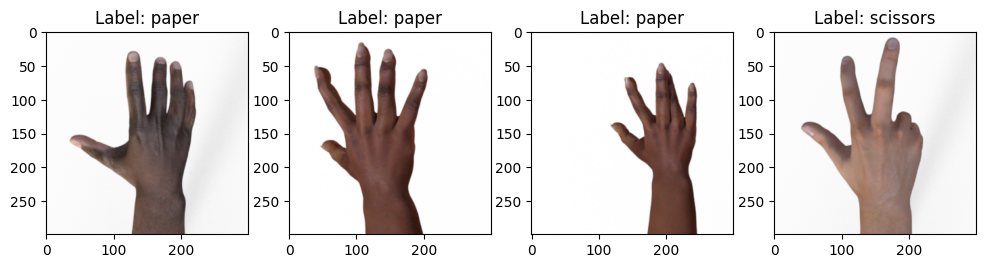

In [ ]:
preview_dataset(valid_data)

In [ ]:
#def preprocess(image, label):
#    image = tf.image.resize(image, (180, 180))
#    image = image / 255.0  # Normalize to [0,1] range
#    print(image)
#    return image, label

train_ds = train_data.shuffle(100).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
valid_ds = valid_data.shuffle(100).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_ds = test_data.shuffle(100).batch(32).prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:
print(train_ds)
print(valid_ds)
print(test_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [ ]:
for image_batch, label_batch in valid_ds.take(1):
  pass

print(image_batch.shape)
print(label_batch)

(32, 300, 300, 3)
tf.Tensor([0 0 2 0 2 0 2 2 0 2 0 0 2 1 2 0 1 0 0 0 2 1 2 0 2 2 0 1 1 1 2 2], shape=(32,), dtype=int64)


In [ ]:
print(len(train_ds))
print(len(valid_ds))

67
12


## lr 1e-5

### 모델 구현

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(300, 300, 3))
#x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(inputs)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'xception_100epch',
        save_best_only=True,
        monitor='val_loss'
    )
]
history = model.fit(
    train_ds,
    epochs=100,
    validation_data=valid_ds,
    callbacks=callbacks)

Epoch 1/100
67/67 [==============================] - 66s 609ms/step - loss: 44.6792 - accuracy: 0.3301 - val_loss: 2.2360 - val_accuracy: 0.3968
Epoch 2/100
67/67 [==============================] - 22s 331ms/step - loss: 37.7595 - accuracy: 0.3277 - val_loss: 2.8560 - val_accuracy: 0.3810
Epoch 3/100
67/67 [==============================] - 27s 409ms/step - loss: 31.3308 - accuracy: 0.3413 - val_loss: 1.7312 - val_accuracy: 0.4418
Epoch 4/100
67/67 [==============================] - 22s 333ms/step - loss: 26.6205 - accuracy: 0.3319 - val_loss: 1.9822 - val_accuracy: 0.3995
Epoch 5/100
67/67 [==============================] - 27s 408ms/step - loss: 23.0852 - accuracy: 0.3277 - val_loss: 1.2195 - val_accuracy: 0.3466
Epoch 6/100
67/67 [==============================] - 23s 339ms/step - loss: 18.6584 - accuracy: 0.3338 - val_loss: 2.7113 - val_accuracy: 0.3280
Epoch 7/100
67/67 [==============================] - 23s 339ms/step - loss: 16.5903 - accuracy: 0.3254 - val_loss: 1.7176 - val_ac

### Train, Validation Accuracy, Loss

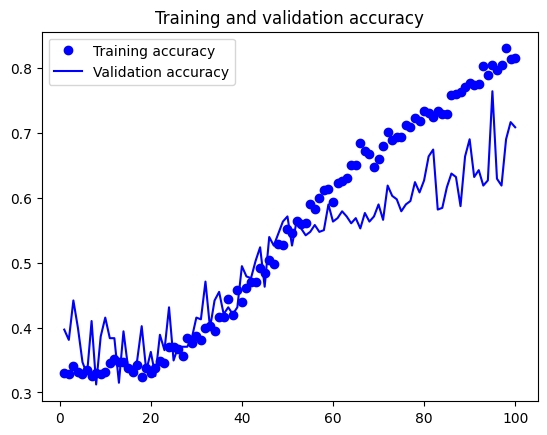

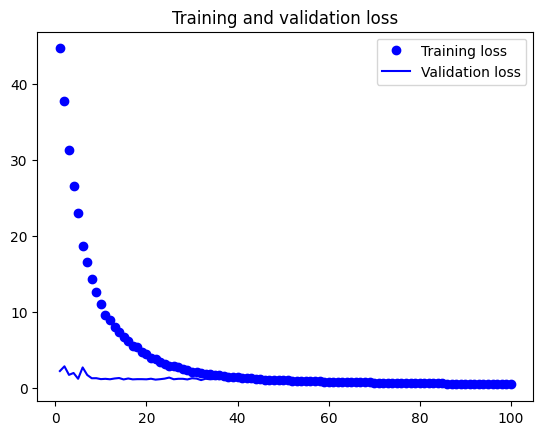

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Testset Evaluation

In [ ]:
test_model = keras.models.load_model('xception_100epch')
test_loss, test_acc = test_model.evaluate(test_ds)
print(f"Test Accuracy : {test_acc}, Test Loss : {test_loss}")

12/12 [==============================] - 3s 238ms/step - loss: 2.8172 - accuracy: 0.5457
Test Accuracy : 0.5456989407539368, Test Loss : 2.8172152042388916


## lr = 1e-4

### 모델 구현

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(300, 300, 3))
#x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(inputs)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'xception_100epch',
        save_best_only=True,
        monitor='val_loss'
    )
]
history = model.fit(
    train_ds,
    epochs=100,
    validation_data=valid_ds,
    callbacks=callbacks)

Epoch 1/100
67/67 [==============================] - 67s 618ms/step - loss: 18.2756 - accuracy: 0.3338 - val_loss: 4.5199 - val_accuracy: 0.3228
Epoch 2/100
67/67 [==============================] - 28s 416ms/step - loss: 5.0487 - accuracy: 0.3165 - val_loss: 1.7027 - val_accuracy: 0.3122
Epoch 3/100
67/67 [==============================] - 28s 419ms/step - loss: 2.7242 - accuracy: 0.3273 - val_loss: 1.3017 - val_accuracy: 0.3254
Epoch 4/100
67/67 [==============================] - 23s 338ms/step - loss: 1.7452 - accuracy: 0.3847 - val_loss: 1.5881 - val_accuracy: 0.3228
Epoch 5/100
67/67 [==============================] - 28s 414ms/step - loss: 1.5178 - accuracy: 0.4104 - val_loss: 1.2004 - val_accuracy: 0.3386
Epoch 6/100
67/67 [==============================] - 24s 359ms/step - loss: 1.2571 - accuracy: 0.4729 - val_loss: 1.3783 - val_accuracy: 0.3386
Epoch 7/100
67/67 [==============================] - 29s 432ms/step - loss: 1.1043 - accuracy: 0.5266 - val_loss: 1.0199 - val_accuracy

### Train, Validation Accuracy, Loss

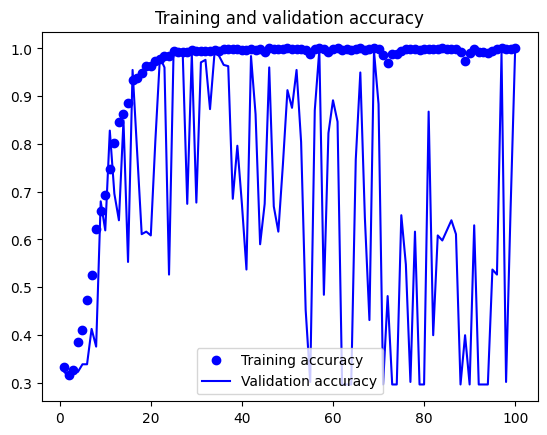

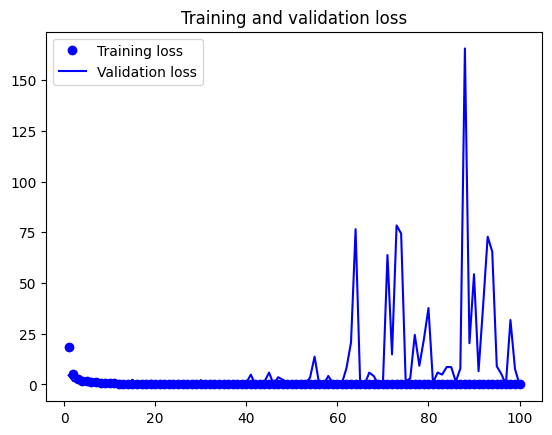

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Testset Evaluation

12/12 [==============================] - 3s 242ms/step - loss: 3.0723 - accuracy: 0.7823
Evaluation Time: 5.435814142227173 seconds
Test Accuracy: 0.7822580933570862
Test Loss: 3.0722994804382324


(0.0, 6.435814142227173)

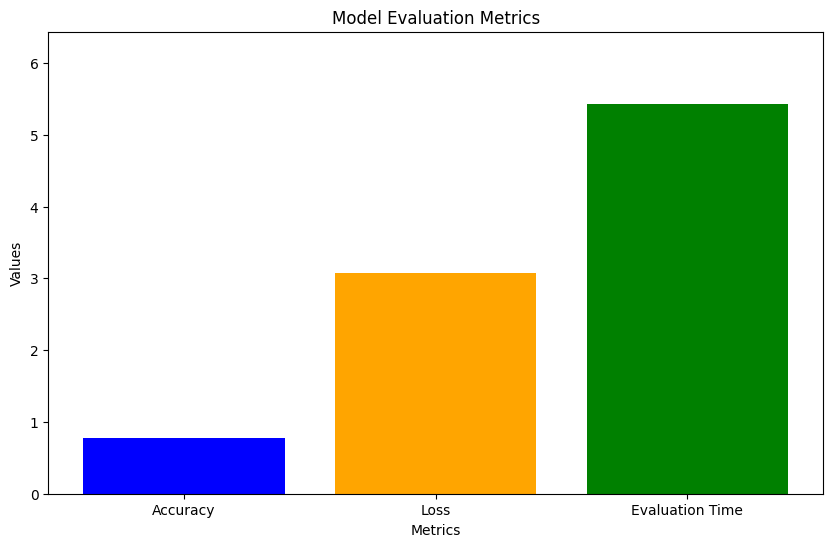

In [ ]:
import time
import matplotlib.pyplot as plt
from tensorflow import keras

test_model = keras.models.load_model('xception_100epch')
start_time = time.time()
test_loss, test_acc = test_model.evaluate(test_ds)
end_time = time.time()
eval_time = end_time - start_time

print(f"Evaluation Time: {eval_time} seconds")
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

#그래프 그리기
metrics = ['Accuracy', 'Loss', 'Evaluation Time']
values = [test_acc, test_loss, eval_time]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'orange', 'green'])
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Model Evaluation Metrics')
plt.ylim(0, max(values) + 1)  # Adjust


## lr = 5e-5

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(300, 300, 3))
#x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(inputs)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=5e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'xception_100epch',
        save_best_only=True,
        monitor='val_loss'
    )
]
history = model.fit(
    train_ds,
    epochs=100,
    validation_data=valid_ds,
    callbacks=callbacks)

Epoch 1/100
67/67 [==============================] - 35s 418ms/step - loss: 29.8590 - accuracy: 0.3287 - val_loss: 4.3256 - val_accuracy: 0.2963
Epoch 2/100
67/67 [==============================] - 22s 335ms/step - loss: 13.2931 - accuracy: 0.3492 - val_loss: 6.0598 - val_accuracy: 0.3228
Epoch 3/100
67/67 [==============================] - 22s 334ms/step - loss: 8.0913 - accuracy: 0.3385 - val_loss: 5.4688 - val_accuracy: 0.3228
Epoch 4/100
67/67 [==============================] - 28s 413ms/step - loss: 5.3092 - accuracy: 0.3441 - val_loss: 2.1360 - val_accuracy: 0.3228
Epoch 5/100
67/67 [==============================] - 23s 336ms/step - loss: 3.7633 - accuracy: 0.3469 - val_loss: 2.4257 - val_accuracy: 0.3228
Epoch 6/100
67/67 [==============================] - 23s 337ms/step - loss: 2.7963 - accuracy: 0.3735 - val_loss: 2.6294 - val_accuracy: 0.3228
Epoch 7/100
67/67 [==============================] - 28s 422ms/step - loss: 2.4374 - accuracy: 0.3637 - val_loss: 1.1443 - val_accurac

### Train, Validation Accuracy, Loss

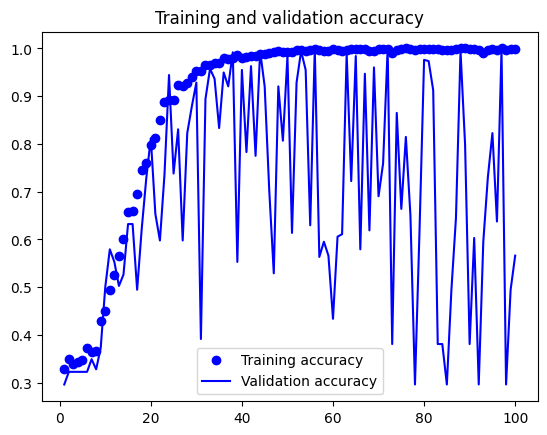

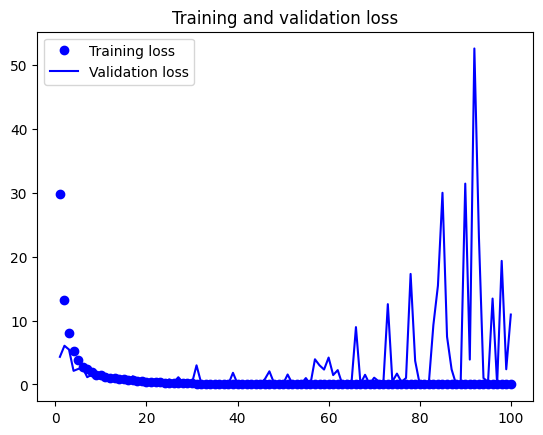

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Testset Evaluation

In [ ]:
test_model = keras.models.load_model('xception_100epch')
test_loss, test_acc = test_model.evaluate(test_ds)
print(f"Test Accuracy : {test_acc}, Test Loss : {test_loss}")

12/12 [==============================] - 1s 78ms/step - loss: 4.7885 - accuracy: 0.6855
Test Accuracy : 0.6854838728904724, Test Loss : 4.7885355949401855


## lr = 2e-5

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(300, 300, 3))
#x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(inputs)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(
        size, 1, strides=2, padding="same", use_bias=False)(residual)
    x = layers.add([x, residual])

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=2e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = 'xception_100epch',
        save_best_only=True,
        monitor='val_loss'
    )
]
history = model.fit(
    train_ds,
    epochs=100,
    validation_data=valid_ds,
    callbacks=callbacks)

Epoch 1/100
67/67 [==============================] - 69s 658ms/step - loss: 52.7655 - accuracy: 0.3333 - val_loss: 3.0048 - val_accuracy: 0.3228
Epoch 2/100
67/67 [==============================] - 27s 411ms/step - loss: 32.7535 - accuracy: 0.3249 - val_loss: 2.5685 - val_accuracy: 0.2963
Epoch 3/100
67/67 [==============================] - 27s 409ms/step - loss: 22.6147 - accuracy: 0.3259 - val_loss: 2.0126 - val_accuracy: 0.2963
Epoch 4/100
67/67 [==============================] - 27s 405ms/step - loss: 14.6792 - accuracy: 0.3483 - val_loss: 1.1153 - val_accuracy: 0.3519
Epoch 5/100
67/67 [==============================] - 22s 333ms/step - loss: 12.1681 - accuracy: 0.3021 - val_loss: 1.1497 - val_accuracy: 0.3360
Epoch 6/100
67/67 [==============================] - 28s 426ms/step - loss: 9.0756 - accuracy: 0.3329 - val_loss: 1.1053 - val_accuracy: 0.3995
Epoch 7/100
67/67 [==============================] - 28s 412ms/step - loss: 6.9245 - accuracy: 0.3553 - val_loss: 1.0880 - val_accu

### Train, Validation Accuracy, Loss

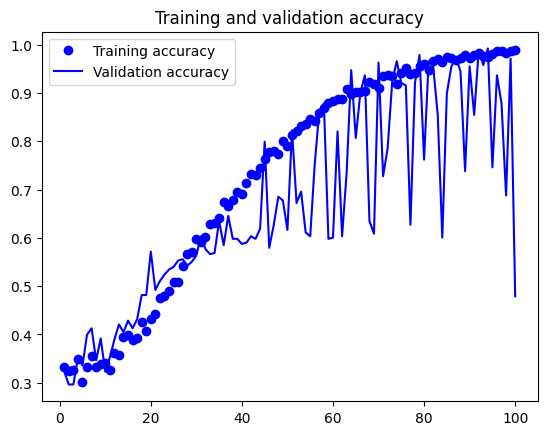

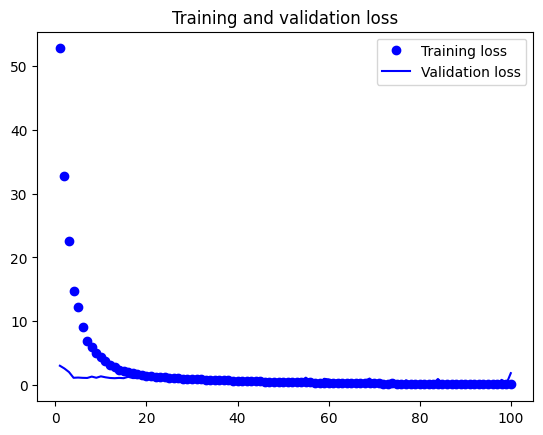

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Testset Evaluation

In [ ]:
test_model = keras.models.load_model('xception_100epch')
test_loss, test_acc = test_model.evaluate(test_ds)
print(f"Test Accuracy : {test_acc}, Test Loss : {test_loss}")

12/12 [==============================] - 3s 228ms/step - loss: 5.4429 - accuracy: 0.6048
Test Accuracy : 0.6048387289047241, Test Loss : 5.44293737411499
